In [1]:
%load_ext autoreload
%autoreload 2
import os
import os.path as osp
import sys
import json
import numpy as np
import torch
import pyvista as pv
import accelerate
from easydict import EasyDict as edict
from termcolor import colored

sys.path.append(os.path.join(os.getcwd(), '..'))

## Environment Setup

In [2]:
def is_vscode() -> bool:
    for var in os.environ:
        if var == "VSCODE_CWD":
            return True
    return False

if is_vscode():
    print(colored("Vscode jupyter DOESN'T support pyvista interative mode", "yellow", force_color=True))
    jupyter_backend = "static"
else:
    jupyter_backend = "trame"

# set this if on remote jupyter
# for headless linux users
os.environ["DISPLAY"] = ":99.0"
os.environ["PYVISTA_OFF_SCREEN"] = "true"
# NOTE: vscode remote jupyter does not work with pyvista
if not is_vscode():
    pv.global_theme.trame.server_proxy_enabled = True

In [3]:
accelerator = accelerate.Accelerator()
device = accelerator.device
device

device(type='cuda')

Write and Load point cloud functions (option)

In [4]:
from plyfile import PlyData, PlyElement

def write_ply(points, save_path):
    """
    points: numpy array in shape (N, 6) or (N, 7)
    save_name: str end with ".ply"
    """
    assert points.shape[1] == 6 or points.shape[1] == 7, "points.shape[1] should be 6 or 7"
    save_path = str(save_path)
    assert save_path.endswith(".ply"), "save_name should end with '.ply'"
    points = [
        (points[i, 0], points[i, 1], points[i, 2], points[i, 3], points[i, 4], points[i, 5])
        for i in range(points.shape[0])
    ]
    vertex = np.array(
        points,
        dtype=[
            ("x", "f4"),
            ("y", "f4"),
            ("z", "f4"),
            ("red", "f4"),
            ("green", "f4"),
            ("blue", "f4"),
        ],
    )
    data = PlyElement.describe(vertex, "vertex", comments=["vertices"])
    PlyData([data]).write(save_path)

def read_ply(save_path):
    filename = save_path
    with open(filename, 'rb') as f:
        plydata = PlyData.read(f)
        num_verts = plydata['vertex'].count
        vertices = np.zeros(shape=[num_verts, 6], dtype=np.float32)
        vertices[:,0] = plydata['vertex'].data['x']
        vertices[:,1] = plydata['vertex'].data['y']
        vertices[:,2] = plydata['vertex'].data['z']
        vertices[:,3] = plydata['vertex'].data['red']
        vertices[:,4] = plydata['vertex'].data['green']
        vertices[:,5] = plydata['vertex'].data['blue']
    return vertices

## Prepare data & models

In [5]:
# load existing args
PROJECT_TOP_DIR = "../../tmp_link_saves"
PROJECT_DIR = osp.join(PROJECT_TOP_DIR, "fps_axisnorm_rr4")
with open(osp.join(PROJECT_DIR, "config.json.txt"), "r") as f:
    args = edict(json.load(f))

### Load data

In [6]:
from data.referit3d.in_out.neural_net_oriented import (
    compute_auxiliary_data,
    load_referential_data,
    load_scan_related_data,
    trim_scans_per_referit3d_data_,
)
# load data
SCANNET_PKL_FILE = "../../datasets/scannet/instruct/global_small.pkl"
REFERIT_CSV_FILE = "../../datasets/nr3d/nr3d_generative_20230825_final.csv"
all_scans_in_dict, scans_split, class_to_idx = load_scan_related_data(SCANNET_PKL_FILE)
referit_data = load_referential_data(args, args.referit3D_file, scans_split)
# Prepare data & compute auxiliary meta-information.
all_scans_in_dict = trim_scans_per_referit3d_data_(referit_data, all_scans_in_dict)
mean_rgb = compute_auxiliary_data(referit_data, all_scans_in_dict)

In [7]:
from transformers import BertTokenizer
# prepare tokenizer
tokenizer = BertTokenizer.from_pretrained(args.bert_pretrain_path)
# Prepare the Listener
n_classes = len(class_to_idx) - 1  # -1 to ignore the <pad> class
pad_idx = class_to_idx["pad"]
# Object-type classification
class_name_list = list(class_to_idx.keys())

class_name_tokens = tokenizer(class_name_list, return_tensors="pt", padding=True)
class_name_tokens = class_name_tokens.to(device)

In [8]:
from data.referit3d.datasets import make_data_loaders
data_loaders = make_data_loaders(
    args=args,
    accelerator=accelerator,
    referit_data=referit_data,
    class_to_idx=class_to_idx,
    scans=all_scans_in_dict,
    mean_rgb=mean_rgb,
    tokenizer=tokenizer,
)

In [39]:
from scripts.train_utils import move_batch_to_device_
# get random data
test_dataset = data_loaders["test"].dataset
rand_idx = np.random.randint(0, len(test_dataset))

In [40]:
rand_data = test_dataset[rand_idx]
print(f"Original text: {rand_data['text']}")
rand_data_3d_objs = test_dataset.get_reference_data(rand_idx)[0].three_d_objects
# rand_data["text"] = "Create a chair on the ground in the corner."
# rand_data["tokens"] = test_dataset.tokenizer(rand_data["text"], max_length=test_dataset.max_seq_len, truncation=True, padding=False)
collate_fn = data_loaders["test"].collate_fn
# get batch
batch = collate_fn([rand_data])
batch = move_batch_to_device_(batch, device)

Original text: Create a couch next to the small table.


### Load models with checkpoints

In [11]:
from models.referit3d_model.referit3d_net import ReferIt3DNet_transformer
from models.point_e_model.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from models.point_e_model.diffusion.sampler import PointCloudSampler
from models.point_e_model.models.configs import MODEL_CONFIGS, model_from_config

# referit3d model
mvt3dvg = ReferIt3DNet_transformer(args, n_classes, class_name_tokens, ignore_index=pad_idx)
# point-e model
point_e_config = MODEL_CONFIGS[args.point_e_model]
point_e_config["cache_dir"] = osp.join(PROJECT_TOP_DIR, "cache", "point_e_model")
point_e_config["n_ctx"] = args.points_per_object
point_e = model_from_config(point_e_config, device)
point_e_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[args.point_e_model])
# move models to gpu
mvt3dvg = mvt3dvg.to(device).eval()
point_e = point_e.to(device).eval()

In [12]:
# load model and checkpoints
mvt3dvg, point_e = accelerator.prepare(mvt3dvg, point_e)
CHECKPOINT_DIR = osp.join(PROJECT_DIR, "checkpoints", "2023-09-18_14-52-06", "ckpt_160000")
accelerator.load_state(CHECKPOINT_DIR)

In [13]:
from models.point_e_model.diffusion.sampler import PointCloudSampler

aux_channels = ["R", "G", "B"]
sampler = PointCloudSampler(
    device=device,
    models=[point_e],
    diffusions=[point_e_diffusion],
    num_points=[args.points_per_object],
    aux_channels=aux_channels,
    guidance_scale=[3.0],
    use_karras=[True],
    karras_steps=[64],
    sigma_min=[1e-3],
    sigma_max=[120],
    s_churn=[3],
)

## Visualization

### Inference

In [41]:
with torch.no_grad():
    ctx_embeds, LOSS, CLASS_LOGITS, LANG_LOGITS, LOCATE_PREDS, pred_xyz = mvt3dvg(batch)

    prompts = batch["text"]
    # stack twice for guided scale
    ctx_embeds = torch.cat((ctx_embeds, ctx_embeds), dim=0)
    samples_it = sampler.sample_batch_progressive(
        batch_size=len(prompts),
        ctx_embeds=ctx_embeds,
        model_kwargs=dict(texts=prompts),
        accelerator=accelerator,
    )
    # get the last timestep prediction
    for last_pcs in samples_it:
        pass
    last_pcs = last_pcs.permute(0, 2, 1)

/home/link/miniconda3/envs/instruct/lib/python3.9/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


In [42]:
# replace last_pcs with the real point cloud
vis_pc = last_pcs.squeeze(0) # (P, 6)

pos = vis_pc[:, :3]
aux = vis_pc[:, 3:]

pred_box_center, pred_box_max_dist = LOCATE_PREDS[0, :3], LOCATE_PREDS[0, 3]

# Process the generated point cloud
coords = pos * pred_box_max_dist + pred_box_center
colors = aux.clamp(0, 255).round()  # (P, 3 or 4)
vis_pc = torch.cat((coords, colors), dim=-1)  # (P, 6)
vis_pc = vis_pc.unsqueeze(0) # (1, P, 6)
vis_pc = vis_pc.cpu().numpy()

### Visualization

1. Create a pyvista point cloud object and generate mesh

In [43]:
batch['scan_id'], batch["text"], batch["ctx_key_padding_mask"].sum().item()

(['scene0334_00'], ['Create a couch next to the small table.'], 55)

In [44]:
# Create a pyvista point cloud object
plotter = pv.Plotter()
# add generated objects
obj = vis_pc[0]
mesh = pv.PolyData(obj[:, :3]).delaunay_3d(alpha=0.005)
color = obj[:, 3:6].astype(np.uint8)
bound = mesh.bounds
plotter.add_box_widget(callback=None, bounds=bound, factor=1.25, outline_translation=False, rotation_enabled=False, color="red")
plotter.add_mesh(mesh, scalars=color, rgb=True, preference='point')
# add context
for obj in rand_data_3d_objs:
    mesh = pv.PolyData(obj.pc).delaunay_3d(alpha=1e-3)
    color = (obj.color * 255).astype(np.uint8)
    plotter.add_mesh(mesh, scalars=color, rgb=True, preference='point')

plotter.show(jupyter_backend=jupyter_backend)

Widget(value="<iframe src='/proxy/47531/index.html?ui=P_0x7f5bc48ced90_6&reconnect=auto' style='width: 99%; he…

In [ ]:
# NOTE: TEST entire point clouds
plotter = pv.Plotter()
# plotter.add_points(batch["ctx_pc"][0, 40, :, :3].cpu().numpy())
plotter.add_points(ctx_pc[:, :3].cpu().numpy())
plotter.show()

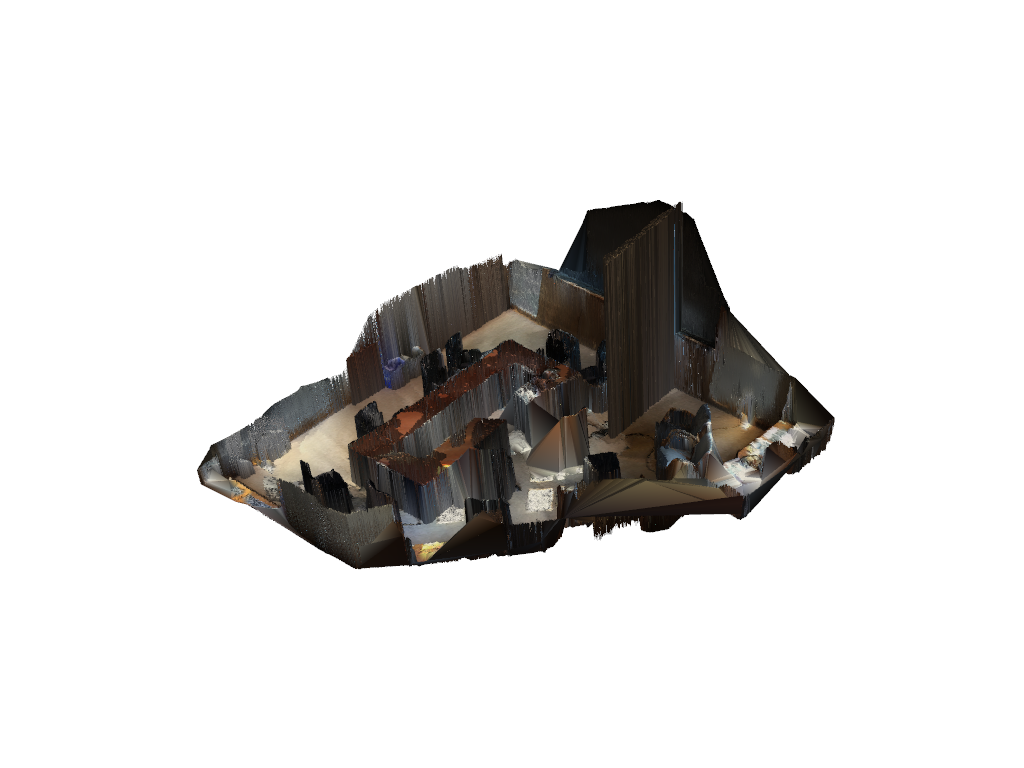

In [43]:
# Read the scene
scan_id = batch["scan_id"][0]
SCAN_PATH = f"../../datasets/scannet/scans/{scan_id}/{scan_id}_vh_clean_2.ply"
# SCAN_PATH = "../../datasets/scannet/scans/scene0000_00/scene0000_00_vh_clean_2.ply"
vertices = read_ply(SCAN_PATH)

# Create a pyvista point cloud object
cloud = pv.PolyData(vertices[:, :3])

# Generate the mesh
mesh = cloud.delaunay_2d()
colors = vertices[:, 3:].astype(np.uint8)

# Plot the mesh
plotter = pv.Plotter()
plotter.add_mesh(mesh, scalars=colors, rgb=True, preference='point')
plotter.show(jupyter_backend=jupyter_backend)

In [ ]:
# TODO - mesh does not have color information
mesh.save('mesh.vtk')